In [122]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import normalized_mutual_info_score as nnmi
from sklearn.metrics import adjusted_rand_score as ari
import sys
sys.path.append("/home/alex/Documents/InformationHeuristic/")
from src.datasets.datasets import mnist_unbalanced_dataset

In [123]:
_,_,full_dataset = mnist_unbalanced_dataset('/home/alex/Documents/InformationHeuristic/data/mnist',random_seed=42,normalize=True)
labels = []
from torch.utils.data import DataLoader
full_dataloader = DataLoader(full_dataset,batch_size=1000,shuffle=False,num_workers=10)
#get the features from a model


In [124]:
from src.models.resnet import ResNetSSL
model = ResNetSSL(
        arch="resnet18",
        in_channels=1,
        proj_dim=128,
        small_images=True,
    )

model.load_state_dict(torch.load(f"/home/alex/Documents/InformationHeuristic/weights/mnistUnbal/representations/simclr/simclr_resnet18_471.00/model.pt",weights_only=False))
model.to('cuda')
labels = []
features = []
with torch.no_grad():
    for batch in full_dataloader:
        labels.append(batch[1])
        features.append(model(batch[0].to('cuda'),return_features=True)[0].cpu())
labels = torch.cat(labels)
features = torch.cat(features)

        

Number of input channels:  1


In [3]:

temps  = [0.354,0.471, 0.626]
num_copies = 5
temps = [f"{temp*1000:.2f}" for temp in temps]

lamb_range = np.arange(0,10)
k_range = np.arange(9,12)
pred_cube = np.zeros((len(temps),len(lamb_range),len(k_range),num_copies,len(labels)))
eval_cube = np.zeros((len(temps),len(lamb_range),len(k_range),num_copies))

for i, lamb in enumerate(temps):
    pred_dict = torch.load(f"/home/alex/Documents/InformationHeuristic/weights/mnistUnbal/augmentation_clustering/iic_aug/iic_aug_simclr_r18_{lamb}/pred_dict.pt")
    nmi_dict = torch.load(f"/home/alex/Documents/InformationHeuristic/weights/mnistUnbal/augmentation_clustering/iic_aug/iic_aug_simclr_r18_{lamb}/nmi_scores.pt",
                          weights_only=False)
    
    new_pred_dict = {}
    new_eval_dict = {}
    
    for key in pred_dict.keys():
        new_key = tuple(int(x) for x in key)
        new_pred_dict[new_key] = pred_dict[key]
    for key in nmi_dict.keys():
        new_key = tuple(int(x) for x in key)
        new_eval_dict[new_key] = nmi_dict[key] 
    pred_dict = new_pred_dict
    nmi_dict = new_eval_dict

    for j,lamb_val in enumerate(lamb_range):
        for u,v in enumerate(k_range):
            for k,k_val in enumerate(range(num_copies)):
                pred_cube[i,j,u,k] = pred_dict[(lamb_val,v,k_val)].numpy()
                eval_cube[i,j,u,k] = nmi_dict[(lamb_val,v,k_val)]
            


In [4]:

I,J,K,N,_ = pred_cube.shape

from sklearn.metrics import normalized_mutual_info_score as nmi
from sklearn.metrics import mutual_info_score as mi
stab_cube = np.zeros((I,J,K,N))
eval_smooth = np.zeros((I,J,K,N))
from tqdm import tqdm
for i in tqdm(range(I)):
    for j in range(J):
        for k in range(K):
            for n in range(N):
                counter = 0
                eval_smooth[i,j,k,n] = eval_cube[i,j,k,n]
                if i==0:
                    stab_cube[i,j,k,n] += nmi(pred_cube[i,j,k,n],pred_cube[i+1,j,k,n])
                    counter += 1
                    eval_smooth[i,j,k,n] += eval_cube[i+1,j,k,n]
                elif i==I-1:
                    stab_cube[i,j,k,n] += nmi(pred_cube[i,j,k,n],pred_cube[i-1,j,k,n])
                    counter += 1
                    eval_smooth[i,j,k,n] += eval_cube[i-1,j,k,n]
                else:
                    stab_cube[i,j,k,n] += nmi(pred_cube[i,j,k,n],pred_cube[i+1,j,k,n])
                    stab_cube[i,j,k,n] += nmi(pred_cube[i,j,k,n],pred_cube[i-1,j,k,n])
                    counter += 2
                    eval_smooth[i,j,k,n] += eval_cube[i+1,j,k,n]+eval_cube[i-1,j,k,n]
                if j == 0:
                    stab_cube[i,j,k,n] += nmi(pred_cube[i,j,k,n],pred_cube[i,j+1,k,n])
                    counter += 1
                    eval_smooth[i,j,k,n] += eval_cube[i,j+1,k,n]
                elif j == J-1:
                    stab_cube[i,j,k,n] += nmi(pred_cube[i,j,k,n],pred_cube[i,j-1,k,n])
                    counter += 1
                    eval_smooth[i,j,k,n] += eval_cube[i,j-1,k,n]
                else:
                    stab_cube[i,j,k,n] += nmi(pred_cube[i,j,k,n],pred_cube[i,j-1,k,n])
                    counter += 1
                    eval_smooth[i,j,k,n] += eval_cube[i,j-1,k,n]
                
                
                stab_cube[i,j,k,n] /= counter
                eval_smooth[i,j,k,n] /= (counter+1)

100%|██████████| 3/3 [00:05<00:00,  1.88s/it]


In [5]:
self_cube = np.zeros((I,J,K,N))
self_eval = np.zeros((I,J,K,N))
for i in range(I):
    for j in range(J):
        for k in range(K):
            for n in range(N):
                #take the self nmi
                copies = [0,1,2,3,4]
                copies.remove(n)
                for c in copies:
                    self_cube[i,j,k,n] += nmi(pred_cube[i,j,k,n],pred_cube[i,j,k,c])
                
                self_cube[i,j,k,n] /= len(copies)
                self_eval[i,j,k,n] = eval_cube[i,j,k,:].mean(axis=-1)

<Axes: >

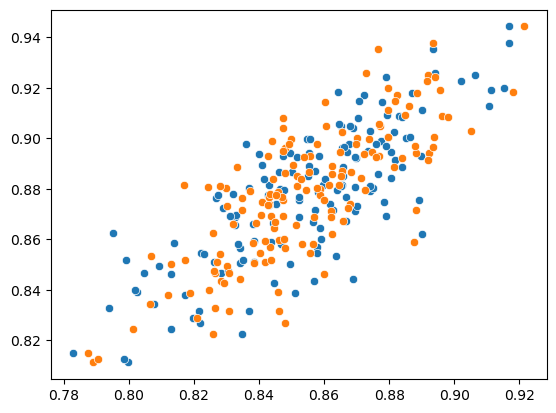

In [28]:
import seaborn as sns
sns.scatterplot(x=self_cube[1,:,:,:].flatten(),y=eval_cube[1,:,:,:].flatten())
sns.scatterplot(x=stab_cube[1,:,:,:].flatten(),y=eval_cube[1,:,:,:].flatten())

In [33]:
train_features = torch.load(f"/home/alex/Documents/InformationHeuristic/weights/mnistUnbal/representations/simclr/simclr_resnet18_471.00/train_features.pt")
test_features = torch.load(f"/home/alex/Documents/InformationHeuristic/weights/mnistUnbal/representations/simclr/simclr_resnet18_471.00/test_features.pt")

In [34]:
features = torch.cat((train_features,test_features),dim=0)

In [125]:
import umap
reducer = umap.UMAP(n_components=2,random_state=42)
embeddings = reducer.fit_transform(features)


/home/alex/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [106]:
from src.datasets.dataset_wrappers import augmentedNearestNeighborDataset,find_knn
nn_indices = find_knn(features,10,metric="cosine")

In [126]:
#run kmeans on the embeddings
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10,random_state=42)
kmeans.fit(embed)
kmeans_labels = kmeans.labels_

<Axes: ylabel='Count'>

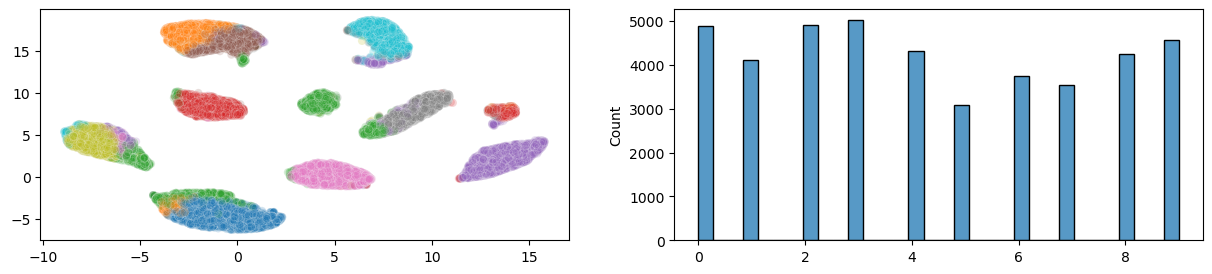

In [134]:
pred = torch.load("/home/alex/Documents/InformationHeuristic/weights/mnistUnbal/scan/scan_simclr_471.00/pred_dict.pt")
pred_labels = pred[(1,10,0)]

f,a = plt.subplots(figsize=(15,3),ncols=2)

sns.scatterplot(x=embed[:,0],y=embed[:,1],hue=pred_labels,palette='tab10',alpha=0.2,ax=a[0],legend=False)
sns.histplot(pred_labels,ax=a[1])

<Axes: >

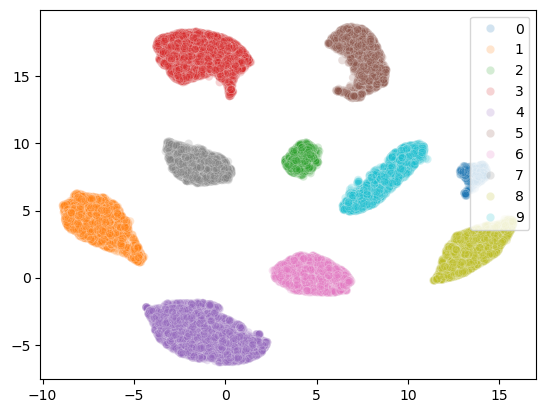

In [86]:
sns.scatterplot(x=embed[:,0],y=embed[:,1],hue=kmeans_labels,palette='tab10',alpha=0.2)

In [76]:
from sklearn.metrics import normalized_mutual_info_score as nmi
nmi(kmeans_labels,labels)

0.9603673702859336

<Axes: ylabel='Count'>

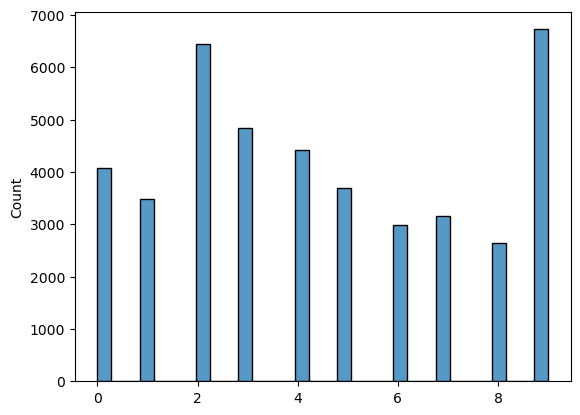

In [66]:
sns.histplot(pred_labels)

<Axes: >

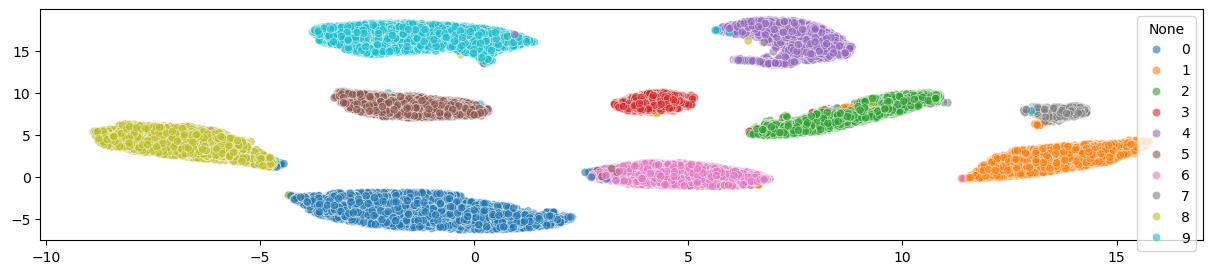

In [70]:
f,a = plt.subplots(figsize=(15,3))
sns.scatterplot(x=embed[:,0],y=embed[:,1],hue=labels,palette='tab10',alpha=0.6)


<Axes: ylabel='Count'>

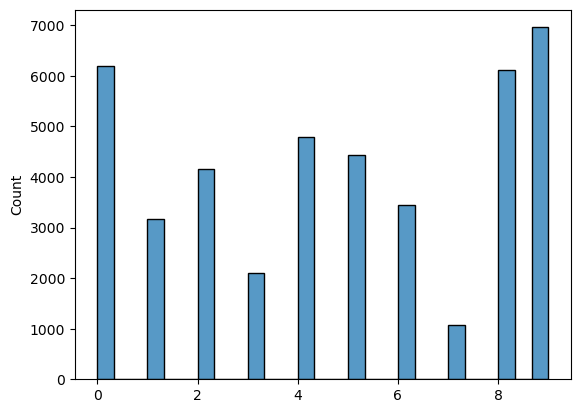

In [68]:
sns.histplot(labels)